In [1]:
import numpy as np
import pandas as pd
import datetime
import pyarrow as pa
import pyarrow.parquet as pq

In [ ]:
df1 = pd.read_csv(r'.\data\NYdata\train.csv',index_col = False)
print(df1.columns)
df1['pickup_datetime'] = pd.to_datetime(df1['pickup_datetime'])
df1['dropoff_datetime'] = pd.to_datetime(df1['dropoff_datetime'])
df1 = df1[df1['pickup_datetime'].dt.month == 6]
df1.sort_values(by = 'pickup_datetime',inplace=True)
df1.reset_index(drop = True,inplace=True)

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')


In [3]:
df2 = pq.read_table(r'.\data\NYdata\yellow_tripdata_2016-06.parquet').to_pandas()
print(df2.columns)
df2['pickup_datetime'] = pd.to_datetime(df2['tpep_pickup_datetime'])
df2['dropoff_datetime'] = pd.to_datetime(df2['tpep_dropoff_datetime'])
df2.sort_values(by = 'pickup_datetime' ,inplace =True)
df2.reset_index(drop = True, inplace = True)
df2 = df2[['pickup_datetime','dropoff_datetime','trip_distance','PULocationID','DOLocationID']]

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')


In [4]:
data = pd.merge(df1,df2,on = ['pickup_datetime','dropoff_datetime'],how='left')
data.dropna(inplace = True)
data['PULocationID'] = data['PULocationID'].astype('int')
data['DOLocationID'] = data['DOLocationID'].astype('int')

In [5]:
print(data.shape)
data.head(3)
data.to_csv(r'.\data\NYdata\data_all.csv')

(235135, 14)


# Pre-processing of data

In [2]:
data = pd.read_csv(r'.\data\NYdata\data_all.csv',index_col = False)
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'])
data['time_period'] = data['pickup_datetime'].dt.hour
data['day_off'] = data['pickup_datetime'].dt.weekday.apply(lambda x: 0 if x<=4 else 1)
data['average_velocity'] = data.apply(lambda x:int(round(x['trip_distance']*1000/x['trip_duration'],0)),axis=1)

In [3]:
data.head()

,Unnamed: 0,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_distance,PULocationID,DOLocationID,time_period,day_off,average_velocity
0,0,id0771174,1,2016-06-01 00:00:13,2016-06-01 00:07:27,2,-73.988297,40.738724,-73.973373,40.748798,N,434,1.30,234,233,0,0,3
1,1,id0298113,2,2016-06-01 00:00:20,2016-06-01 00:12:17,1,-73.995468,40.717178,-73.976837,40.752090,N,717,2.78,148,162,0,0,4
2,2,id3971468,2,2016-06-01 00:00:20,2016-06-01 00:18:05,3,-74.007919,40.740410,-73.972733,40.755322,N,1065,3.07,158,162,0,0,3
3,3,id0233215,1,2016-06-01 00:00:38,2016-06-01 00:20:00,1,-73.870758,40.773689,-73.952774,40.823425,N,1162,7.90,138,116,0,0,7
4,4,id1103879,1,2016-06-01 00:00:42,2016-06-01 00:12:31,1,-73.974464,40.793457,-73.978943,40.761196,N,709,2.40,238,161,0,0,3


In [28]:
data = data[data['pickup_datetime'].dt.day <= 7]
cluster_data = pd.concat([data[['pickup_datetime','pickup_longitude','pickup_latitude']],
                        data[['pickup_datetime','pickup_longitude','pickup_latitude']]],
                         ignore_index=True)
cluster_data.columns = ['time','lon','lat']

In [5]:
cluster_data

,time,lon,lat
0,2016-06-01 00:00:13,-73.988297,40.738724
1,2016-06-01 00:00:20,-73.995468,40.717178
2,2016-06-01 00:00:20,-74.007919,40.740410
3,2016-06-01 00:00:38,-73.870758,40.773689
4,2016-06-01 00:00:42,-73.974464,40.793457
...,...,...,...
113033,2016-06-07 23:59:17,-73.989235,40.769337
113034,2016-06-07 23:59:26,-74.003181,40.743252
113035,2016-06-07 23:59:35,-73.988708,40.736645
113036,2016-06-07 23:59:40,-73.972244,40.749985


# ST-DBSCAN

In [6]:
from stdbscan import STDBSCAN
import warnings
warnings.filterwarnings("ignore")

In [29]:
model = STDBSCAN(spatial_threshold=0.008, temporal_threshold=3600, # 0.003 7200 10
                 min_neighbors=40, progress_bar = True)
result = model.fit_transform(cluster_data, 'lat', 'lon', 'time')

Clustering 进度: 113038/113038

In [30]:
result.groupby('cluster').count()
print('共有坐标点{}个，其中噪声点{}个，噪声比{}%'.format(len(result),
                                       len(result[result['cluster']==-1]),
                                          len(result[result['cluster'] == -1])/len(result)*100))
print('有效分类簇个数为{}个'.format(max(result['cluster'])))

共有坐标点113038个，其中噪声点10990个，噪声比9.722394239105434%
有效分类簇个数为47个


In [31]:
result.to_csv(r'.\result\NY_Cluster_result_4_1-7.csv',index = False)

In [29]:
result = pd.read_csv(r'.\result\NY_Cluster_result_4_1-7.csv')
print(result.shape[0],data.shape[0])
data['start_cluster'] = result.loc[0:len(data)-1,'cluster'].copy().values
data['end_cluster'] = result.loc[len(data):,'cluster'].copy().values
data = data[(data['start_cluster'] != -1) | (data['end_cluster']!=-1)]
data.reset_index(inplace = True)
data.head()

113038 56519


,index,Unnamed: 0,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,...,store_and_fwd_flag,trip_duration,trip_distance,PULocationID,DOLocationID,time_period,day_off,average_velocity,start_cluster,end_cluster
0,0,0,id0771174,1,2016-06-01 00:00:13,2016-06-01 00:07:27,2,-73.988297,40.738724,-73.973373,...,N,434,1.30,234,233,0,0,3,1,1
1,1,1,id0298113,2,2016-06-01 00:00:20,2016-06-01 00:12:17,1,-73.995468,40.717178,-73.976837,...,N,717,2.78,148,162,0,0,4,2,2
2,6,6,id3525943,2,2016-06-01 00:01:01,2016-06-01 00:09:28,1,-73.978027,40.766529,-73.951363,...,N,507,2.16,43,263,0,0,4,1,1
3,9,9,id2804843,1,2016-06-01 00:01:21,2016-06-01 00:17:42,1,-73.965240,40.759319,-74.017265,...,N,981,6.50,229,13,0,0,7,1,1
4,10,10,id1473577,1,2016-06-01 00:02:49,2016-06-01 00:10:48,1,-73.987358,40.738941,-73.982765,...,N,479,1.50,234,4,0,0,3,1,1


In [34]:
record = pd.DataFrame(index=[x for x in range(1,266)],columns=['PULocationID Count','DOLocationID Count'])
record.iloc[:] = 0

for i in range(len(data)):
    row = data.loc[i,'PULocationID']
    col = data.loc[i,'DOLocationID']
    if row>0:
        record.loc[row,'PULocationID Count'] += 1
    if col>0:
        record.loc[col,'DOLocationID Count'] += 1

array([ 1,  2, -1, ..., 42, 42, 42], dtype=int64)

In [23]:
start_clusters = list(data['PULocationID'].copy().sort_values().drop_duplicates())
end_clusters = list(data['DOLocationID'].copy().sort_values().drop_duplicates())
AOIs_ID = []
for i in start_clusters:
    if (i not in AOIs_ID):
        AOIs_ID.append(i)
for j in end_clusters:
    if (j not in AOIs_ID):
        AOIs_ID.append(j)

print('='*50)
print('total number of clusters:',len(AOIs_ID))
print('the number of pick-up AOIs:',len(start_clusters))
print('the number of drop-off AOIs:',len(end_clusters))

total number of clusters: 229
the number of pick-up AOIs: 66
the number of drop-off AOIs: 229


# Bayesian Network

In [3]:
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import HillClimbSearch, BDeuScore,K2Score
from pgmpy.metrics import structure_score
BN_data = data.loc[:,['PULocationID','DOLocationID','day_off','time_period','average_velocity']]
BN_data = BN_data[BN_data['average_velocity']<=18]

In [5]:
# Structure Learning by 
est = HillClimbSearch(BN_data)
BN = est.estimate(scoring_method=BDeuScore(BN_data),fixed_edges = [('PULocationID','DOLocationID')])

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [10]:
sorted(BN.edges())

[('DOLocationID', 'average_velocity'),
 ('PULocationID', 'DOLocationID'),
 ('average_velocity', 'day_off'),
 ('average_velocity', 'time_period'),
 ('day_off', 'time_period')]

In [11]:
model1 =  BayesianNetwork([('PULocationID','DOLocationID'),
                      ('time_period','DOLocationID'),
                      ('day_off','DOLocationID'),
                      ('PULocationID','average_velocity'),
                     ('DOLocationID','average_velocity'),
                     ('time_period','average_velocity')])
model2 = BayesianNetwork([('DOLocationID', 'average_velocity'),
                          ('PULocationID', 'DOLocationID'),
                          ('average_velocity', 'day_off'),
                          ('average_velocity', 'time_period'),
                          ('day_off', 'time_period')])
print('自定义模型的评分：',structure_score(model1, BN_data, scoring_method="k2"))
print('结构学习最佳模型评分：',structure_score(model2, BN_data, scoring_method="k2"))

自定义模型的评分： -4023899.6269931067
结构学习最佳模型评分： -3185166.650832804


In [4]:
# set up Model

BN = BayesianNetwork([('PULocationID','DOLocationID'),
                      ('time_period','DOLocationID'),
                      ('day_off','DOLocationID'),
                      ('PULocationID','average_velocity'),
                     ('DOLocationID','average_velocity'),
                     ('time_period','average_velocity')])
BN.fit(BN_data)

In [5]:
# estimate CPDS
estimator = BayesianEstimator(BN, BN_data)

# pseudo_counts为先验信息虚拟count ， 见 estimator.estimate_cpd 的 sample


cpd = estimator.estimate_cpd(node='DOLocationID')


In [6]:
# ['end_cluster', 'CALL_TYPE', 'DAY_TYPE', 'TIME_TYPE', 'start_cluster']
print(cpd.values.shape)
# ['end_cluster', 'CALL_TYPE' , 'TIME_TYPE', 'start_cluster']
CPD = np.squeeze(cpd.values)
print(CPD.shape)
# print(cpd.no_to_name)

# 计算不同start_cluster每个时间段的转移
def Relative_Probability(CPD,rela_mat = [0,3],normalize = None):
    rela_mat.sort()
    if len(CPD.shape) < 2:
        print(f'输入CPD矩阵维度{CPD.shape}，不等于2！')
        return
    if len(rela_mat) != 2:
        print(f'相对概率的输入索引mat应为[x,y]，为两列')
        return
    allindex = [i for i in range(len(CPD.shape))]
    num = [i for i in allindex if i not in rela_mat]

    t = 1
    for i in range(len(num)):
        t *= CPD.shape[num[i]]

    CPD = np.array(CPD)
    mat = np.zeros((CPD.shape[rela_mat[0]],CPD.shape[rela_mat[1]]))
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            temp = CPD.take(indices=i,axis=rela_mat[0])
            temp = temp.take(indices=j,axis=rela_mat[1]-1)
            mat[i,j] = temp.reshape(1,-1).sum()/t

    if normalize==0:
        for i in range(len(mat[:,0])):
            mat[i,:] = mat[i,:]/mat[i,:].sum()
    elif normalize == 1:
        for i in range(len(mat[0,:])):
            mat[:,i] = mat[:,i]/mat[:,i].sum()
    return np.array(mat)


(256, 220, 2, 24)
(256, 220, 2, 24)


# Plot Figures

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Times New Roman'] 

Text(33.0, 0.5, 'End_Cluster')

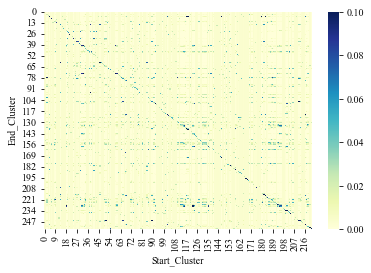

In [9]:

RP = Relative_Probability(CPD,rela_mat = [0,1])
sns.heatmap(RP,vmin=0,             #刻度阈值
                 vmax=0.1,cmap="YlGnBu")

plt.xlabel("Start_Cluster",size=10)
plt.ylabel("End_Cluster",size=10)

In [5]:
names = pd.read_csv(r'.\data\NYdata\yellow_6_1-7_count.csv',index_col=False)
names = names.iloc[:,0]
names = list(names)
np.save('names.npy',names)

In [ ]:
nodes = [cpd.name_to_no['PULocationID'][i] for i in names]
print(len(names)==len(nodes))

In [80]:
P(DOLocationID:256 | PULocationID:222, day_off:2, time_period:24)

<bound method StateNameMixin.get_state_names of <TabularCPD representing P(DOLocationID:256 | PULocationID:222, day_off:2, time_period:24) at 0x256143e47c0>>

In [9]:
BN_data = BN_data = data.loc[:,['PULocationID','DOLocationID','day_off','time_period','average_velocity']]
def fun(x):
    if x <= 3:
        return 0
    elif (x > 3) and (x <=5):
        return 1
    elif (x > 5) and (x <=8):
        return 2
    elif (x > 8) and (x <=10):
        return 3
    else:
        return 4
BN_data['average_velocity'] = BN_data['average_velocity'].apply(fun)
estimator = BayesianEstimator(BN, BN_data)



In [14]:
cpd1 = estimator.estimate_cpd(node='day_off')
mat1 = cpd1.values/cpd1.values.sum()
cpd2 = estimator.estimate_cpd(node='time_period')
mat2 = cpd2.values/cpd2.values.sum()

cpd3 = estimator.estimate_cpd(node='PULocationID')
nodes = [cpd3.name_to_no['PULocationID'][i] for i in names]
mat3 = cpd3.values[nodes]/cpd3.values[nodes].sum()
print(mat1)
print(mat2)
print(mat3)

[0.73693757 0.26306243]
[0.03905847 0.02721871 0.01898107 0.01409036 0.01096457 0.0107817
 0.02421199 0.03875652 0.04664119 0.04744496 0.04517823 0.04810414
 0.04951607 0.04891643 0.04966492 0.04662843 0.04223105 0.04932895
 0.0602501  0.06060733 0.05469596 0.05868933 0.05715832 0.05088121]
[0.01176696 0.01594199 0.03566059 0.01151742 0.02818874 0.03462884
 0.02122556 0.02130234 0.02818874 0.01883092 0.01568285 0.02654272
 0.0137633  0.0309145  0.01969472 0.02606763 0.03053059 0.01152702
 0.01338419 0.01737206 0.01512618 0.04042108 0.03808883 0.02984915
 0.02774244 0.03711945 0.03837676 0.02171984 0.03488797 0.02236769
 0.01540932 0.03739299 0.03943252 0.04339639 0.02101441 0.02817434
 0.01751602 0.02478633 0.01443514 0.02001144]


In [10]:
from pgmpy.inference import VariableElimination
inference = VariableElimination(BN)

In [11]:
weekday = inference.query(['PULocationID','time_period'],evidence={'DOLocationID':237,'day_off':0})
weekend = inference.query(['PULocationID','time_period'],evidence={'DOLocationID':237,'day_off':1})

In [44]:
node1 = [weekday.name_to_no['PULocationID'][i] for i in names]
node2 = [weekend.name_to_no['PULocationID'][i] for i in names]
Relative_Probability(weekday.values,rela_mat = [0,1],normalize=0).shape

C:\Windows\Temp\ipykernel_15116\1010023938.py:34: RuntimeWarning: invalid value encountered in true_divide
  mat[i,:] = mat[i,:]/mat[i,:].sum()


(220, 24)

In [14]:
# 变量消除法推断
inference.query(['DOLocationID'], ).values.sum()

0.9999999999999999

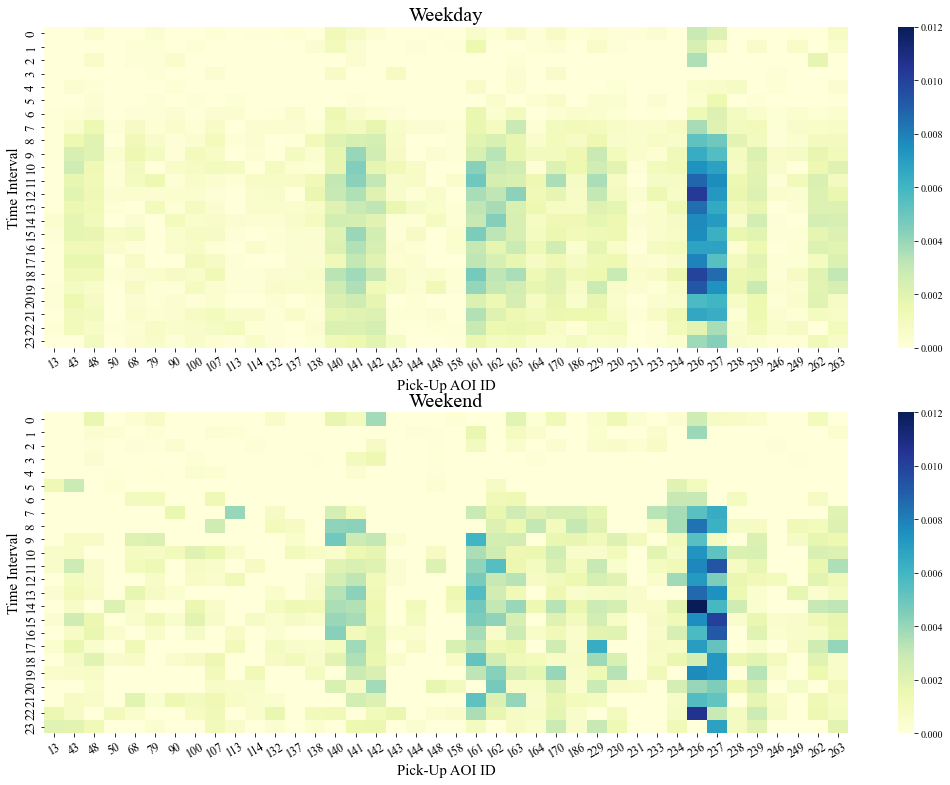

In [57]:
RP = Relative_Probability(weekday.values[node1],rela_mat = [0,1]).T
plt.figure(figsize=(18,13))
ax = plt.subplot(211)
sns.heatmap(RP,vmin=0,             #刻度阈值
                 vmax=0.012,cmap="YlGnBu")
ax.set_xticklabels(names,rotation = 30,size=12)

plt.yticks(size=13)
plt.xlabel("Pick-Up AOI ID",size=15)
plt.ylabel("Time Interval",size=15)
plt.title('Weekday',size = 20)

ax = plt.subplot(212)
RP = Relative_Probability(weekend.values[node1],rela_mat = [0,1]).T
sns.heatmap(RP,vmin=0,             #刻度阈值
                 vmax=0.012,cmap="YlGnBu")
ax.set_xticklabels(names,rotation = 30,size=12)
plt.yticks(size=13)
plt.xlabel("Pick-Up AOI ID",size=15)
plt.ylabel("Time Interval",size=15)
plt.title('Weekend',size = 20)
plt.savefig(r'F:\文献\taxi-trajectory\fig1.jpg',dpi=600)

In [18]:
print(cpd.store_state_names)


<bound method StateNameMixin.store_state_names of <TabularCPD representing P(DOLocationID:256 | PULocationID:220, day_off:2, time_period:24) at 0x1b92e09d430>>


# Analysis for Velocity

In [52]:
BN_data = BN_data = data.loc[:,['PULocationID','DOLocationID','day_off','time_period','average_velocity']]
def fun(x):
    if x <= 3:
        return 0
    elif (x > 3) and (x <=5):
        return 1
    elif (x > 5) and (x <=8):
        return 2
    elif (x > 8) and (x <=10):
        return 3
    else:
        return 4
BN_data['average_velocity'] = BN_data['average_velocity'].apply(fun)

BN = BayesianNetwork([('PULocationID','DOLocationID'),
                      ('time_period','DOLocationID'),
                      ('day_off','DOLocationID'),
                      ('PULocationID','average_velocity'),
                     ('DOLocationID','average_velocity'),
                     ('time_period','average_velocity')])
BN.fit(BN_data,estimator=BayesianEstimator)


11.439252537671699


<BarContainer object of 24 artists>

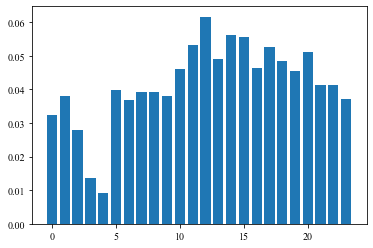

In [25]:
# 计算 sample node 到哪个时间段概率最高

RP = Relative_Probability(CPD[nodes,sample_node,:,:], rela_mat=[0,2])
print(RP.sum())
RP = RP.sum(axis=0)/RP.sum()
plt.bar([i for i in range(len(RP))],RP)

# RP_df.to_csv('./result/AOI132_Destination.csv', index=False)

In [53]:
predict_data=pd.DataFrame(columns = ['DOLocationID','PULocationID','day_off','time_period'])
pre_mat = pd.DataFrame(index = [0,1,2,3,4],columns = names)

# AOIs and 速度
for i in names:
    predict_data.loc[0,:] = [i,132,0,12]
    
    pre_mat.loc[0:4,i] = BN.predict_probability(predict_data).values.reshape(-1)



In [57]:
pre_mat.to_csv('./result/AOI132_average_velocity.csv')


In [55]:
pre_mat

,13,43,48,50,68,79,90,100,107,113,...,233,234,236,237,238,239,246,249,262,263
0,0.0,0.2,0.0,0.999997,0.000001,0.0,0.000001,0.0,0.0,0.0,...,0.0,0.0,0.0,0.499999,0.2,0.2,0.2,0.000001,0.000001,0.0
1,0.0,0.2,0.749999,0.000001,0.000001,0.0,0.999997,0.333333,0.0,0.0,...,0.0,0.499999,0.0,0.0,0.2,0.2,0.2,0.999997,0.000001,0.0
2,0.499999,0.2,0.25,0.000001,0.999997,0.999999,0.000001,0.666666,0.25,0.999999,...,0.999999,0.0,0.999999,0.499999,0.2,0.2,0.2,0.000001,0.999997,0.999999
3,0.499999,0.2,0.0,0.000001,0.000001,0.0,0.000001,0.0,0.749999,0.0,...,0.0,0.499999,0.0,0.0,0.2,0.2,0.2,0.000001,0.000001,0.0
4,0.0,0.2,0.0,0.000001,0.000001,0.0,0.000001,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.2,0.2,0.2,0.000001,0.000001,0.0


In [19]:
from pgmpy.inference import VariableElimination
from pgmpy.models import BayesianNetwork
import numpy as np
import pandas as pd
values = pd.DataFrame(np.random.randint(low=0, high=2, size=(1000, 5)),
                      columns=['A', 'B', 'C', 'D', 'E'])
model = BayesianNetwork([('A', 'B'), ('C', 'B'), ('C', 'D'), ('B', 'E')])
model.fit(values)
inference = VariableElimination(model)
phi_query = inference.query(['A', 'B'],evidence=)

In [22]:
print(phi_query)

+------+------+------------+
| A    | B    |   phi(A,B) |
+======+======+============+
| A(0) | B(0) |     0.2340 |
+------+------+------------+
| A(0) | B(1) |     0.2690 |
+------+------+------------+
| A(1) | B(0) |     0.2460 |
+------+------+------------+
| A(1) | B(1) |     0.2510 |
+------+------+------------+


# 地图剪裁

In [4]:
import pandas
import pyproj
import geopandas as gp

shpdata = gp.read_file(r'.\data\NYdata\taxi_zones\taxi_zones.shx')

shpdata = shpdata.to_crs(epsg=4326)
shpdata['centroid'] = shpdata.centroid
# shpdata.to_file(r'.\data\NYdata\taxi_zones.geojson',driver="GeoJSON", encoding='utf-8')

C:\Windows\Temp\ipykernel_14020\33422418.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shpdata['centroid'] = shpdata.centroid


In [25]:
idx = []
for i in range(len(shpdata)):
    if i+1 not in names:
        idx.append(i)

In [23]:
shpdata.drop(index = idx).to_file(r'.\data\NYdata\taxi_zones_clip1.geojson',driver="GeoJSON", encoding='utf-8')
idx.append(138-1)
idx.append(132-1)
shpdata.drop(index = idx).to_file(r'.\data\NYdata\taxi_zones_clip2.geojson',driver="GeoJSON", encoding='utf-8')

In [26]:
shpdata.drop(index = idx).to_csv(r'.\data\NYdata\taxi_zones_clip1.csv', encoding='utf-8')
idx.append(138-1)
idx.append(132-1)
shpdata.drop(index = idx).to_file(r'.\data\NYdata\taxi_zones_clip2.csv', encoding='utf-8')

TypeError: Cannot interpret '<geopandas.array.GeometryDtype object at 0x000002A9C5E59430>' as a data type